In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
!python setup.py develop

running develop
running egg_info
writing pylib.egg-info/PKG-INFO
writing dependency_links to pylib.egg-info/dependency_links.txt
writing top-level names to pylib.egg-info/top_level.txt
reading manifest file 'pylib.egg-info/SOURCES.txt'
writing manifest file 'pylib.egg-info/SOURCES.txt'
running build_ext
Creating /store17/petrov/anaconda3/lib/python3.7/site-packages/pylib.egg-link (link to .)
pylib 0.1 is already the active version in easy-install.pth

Installed /spoolA/petrov/refac20/notebooks
Processing dependencies for pylib==0.1
Finished processing dependencies for pylib==0.1


In [3]:
import pylib.preprocess_data.kskl as kskl
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline
plt.style.use('pylib/cmd1202.mplstyle')

In [4]:
df_total_info = kskl.season_csv_table('HIGH19')
df_total_info.head()

,elabel,emeas,exp_tree,lum_exp,lum_exp_err,mc_raw_kskl_mcgpj,mc_tree_kskl_mcgpj,mc_tree_kskl_uniform,mlt_raw,ksklpi0_raw,4pi_raw
0,537.5_70914,537.457000,root://sl10cmd//scan2019/scan2019_tr_ph_fc_e53...,1240.650,1.65512,/store17/petrov/data/kskl20/raw/19/kskl_537.5_...,/store17/petrov/data/kskl20/tr_ph/19/tr_ph_ksk...,/store17/petrov/data/kskl_uniform_individual/1...,/store17/petrov/data/kskl20/tr_ph/multi/19/tr_...,NaN,NaN
1,550_70260,549.349000,root://sl10cmd//scan2019/scan2019_tr_ph_fc_e55...,1442.760,1.82450,/store17/petrov/data/kskl20/raw/19/kskl_550_70...,/store17/petrov/data/kskl20/tr_ph/19/tr_ph_ksk...,/store17/petrov/data/kskl_uniform_individual/1...,/store17/petrov/data/kskl20/tr_ph/multi/19/tr_...,NaN,NaN
2,NaN,NaN,root://sl10cmd//scan2019/scan2019_tr_ph_fc_e55...,501.898,1.07184,NaN,NaN,/store17/petrov/data/kskl_uniform_individual/1...,NaN,NaN,NaN
3,562.5_71178,562.497620,root://sl10cmd//scan2019/scan2019_tr_ph_fc_e56...,1060.560,1.60288,/store17/petrov/data/kskl20/raw/19/kskl_562.5_...,/store17/petrov/data/kskl20/tr_ph/19/tr_ph_ksk...,/store17/petrov/data/kskl_uniform_individual/1...,NaN,NaN,NaN
4,575_71544,574.855896,root://sl10cmd//scan2019/scan2019_tr_ph_fc_e57...,1064.290,1.64152,/store17/petrov/data/kskl20/raw/19/kskl_575_71...,/store17/petrov/data/kskl20/tr_ph/19/tr_ph_ksk...,/store17/petrov/data/kskl_uniform_individual/1...,/store17/petrov/data/kskl20/tr_ph/multi/19/tr_...,45877.0,NaN


In [5]:
# import uproot
# from tqdm import tqdm
# for i, row in tqdm(df_total_info.iterrows()):
#     tr_ph = uproot.open(row['exp_tree'])['tr_ph']
#     df_total_info.at[i, 'emeas'] = tr_ph['emeas'].array(entry_stop=10)[0]
# df_total_info['mlt_raw'] = '/store17/petrov/data/kskl20/tr_ph/multi/12/tr_ph_run0' + df_total_info['mlt_raw'].astype(str) + '.root'

In [6]:
# df_total_info.to_csv('data/HIGH12.csv', index=False)

In [ ]:
from tqdm import tqdm
SEASON = 'HIGH19'
def process_season(df_total_info):
    for i, row in tqdm(df_total_info.iterrows()):
        if i<4:
            continue
        elabel = row['elabel']
        print(elabel)
        ebeam = row['emeas']

        try:
            tr_ph = kskl.open_tree(row['exp_tree'])
            tr_ph_mc = kskl.open_tree(row['mc_tree_kskl_mcgpj'])
            tr_ph_mlt = kskl.open_tree(row['mlt_raw'])
        except ValueError:
            continue

        df = kskl.selection_df(tr_ph, finalstate_id=False, trigbits=True, remove_badruns=True)
        df.to_csv(f'../csv/{SEASON}/exp_tree/{elabel}.csv', float_format='%.4f', index=False)
        del df

        df_mc = kskl.selection_df(tr_ph_mc, finalstate_id=True)
        df_mc.to_csv(f'../csv/{SEASON}/mc_tree_kskl_mcgpj/{elabel}.csv', float_format='%.4f', index=False)
        del df_mc

        df_mlt = kskl.selection_df(tr_ph_mlt, finalstate_id=True)
        df_mlt.to_csv(f'../csv/{SEASON}/mlt_raw/{elabel}.csv', float_format='%.4f', index=False)
        del df_mlt
#         break
process_season(df_total_info)

0it [00:00, ?it/s]

575_71544


5it [02:31, 30.35s/it]

587.5_71908


6it [05:13, 59.49s/it]

600_72268


## Process points

In [10]:
idx = 0
elabel = df_total_info.at[idx, 'elabel']
ebeam = df_total_info.at[idx, 'emeas']
df_total_info.loc[idx]

elabel                                                          640_14606
mlt_raw                 /store17/petrov/data/kskl20/tr_ph/multi/12/tr_...
mc_tree_kskl_mcgpj      /store17/petrov/data/kskl20/tr_ph/12/tr_ph_ksk...
exp_tree                root://sl10cmd//scan2012/scan2012_tr_ph_fc_e64...
mc_tree_kskl_uniform    /store17/petrov/data/kskl_uniform_individual/1...
lum_exp                                                           725.306
lum_exp_err                                                       1.50728
emeas                                                          638.530029
Name: 0, dtype: object

In [11]:
def two_body_mask(df, eband):
    mask = kskl.cut_two_body_decay_angle(df.kspipt0, df.ksdpsi, ebeam_band=eband)
    mask = kskl.cut_two_body_decay_angle(df.kspipt1, df.ksdpsi, ebeam_band=eband)&mask
    return mask

from pylib.preprocess_data.kskl import get_x
def point_cut(df, ebeam: float):
    dfq = df.query('ksalign>0.8').copy()
    
    eband = (max(0.93*ebeam, 525), 1.07*ebeam)
    mask = two_body_mask(dfq, eband)
    dfq = dfq[mask]
    
    x1, x2 = get_x(dfq.ksminv, dfq.ksptot, ebeam)
    dfq = dfq.assign(x1=x1, x2=x2)
    return dfq


def process_point(df_total_info, idx: int, return_raw: bool = False, plot_cuts: bool = False) -> list:
    mPc = 139.6
    elabel = df_total_info.at[idx, 'elabel']
    ebeam = df_total_info.at[idx, 'emeas']
    print(f'Elabel: {elabel}')
    
    df = pd.read_csv(f'../csv/{SEASON}/exp_tree/{elabel}.csv')
    df_mc = pd.read_csv(f'../csv/{SEASON}/mc_tree_kskl_mcgpj/{elabel}.csv')
    df_mlt = pd.read_csv(f'../csv/{SEASON}/mlt_raw/{elabel}.csv')
    if return_raw:
        return [ebeam, df, df_mc, df_mlt]
    
    dfq = point_cut(df, ebeam)
    df_mcq = point_cut(df_mc, ebeam)
    df_mltq = point_cut(df_mlt, ebeam)
    
    return [ebeam, dfq, df_mcq, df_mltq]

In [12]:
fit_df = pd.DataFrame()

Cycle

In [13]:
import pylib.fit as pyfit
import pylib.style as pys
import iminuit

In [392]:
it = df_total_info.iterrows()

--------

In [393]:
idx, row = next(it)
elabel = row['elabel']
ebeam, dfq, df_mcq, df_mltq = process_point(df_total_info, idx, return_raw=False)

Elabel: 640_14606


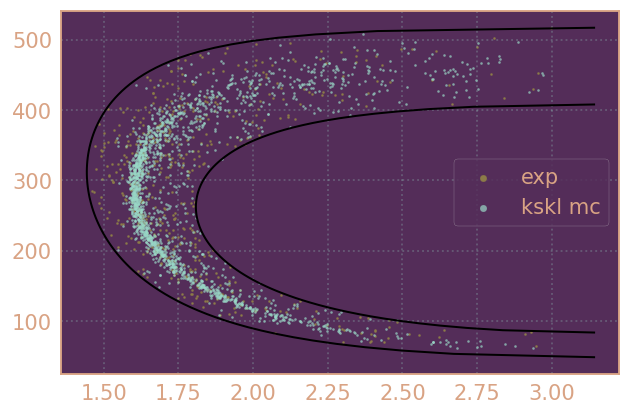

In [394]:
eband = (max(0.93*ebeam, 525), 1.07*ebeam)

momp, angp = kskl.two_body_decay_angle(eband[0], 100)
momm, angm = kskl.two_body_decay_angle(eband[1], 100)

plt.scatter(dfq.ksdpsi, dfq.kspipt1, s=7, label='exp')
plt.scatter(df_mcq.ksdpsi, df_mcq.kspipt1, s=7, alpha=0.7, label='kskl mc')
plt.legend()
plt.plot(angp, momp, color='black')
plt.plot(angm, momm, color='black')
# plt.xlim(None, 2)

In [395]:
fit_range_bkg = (-23, 23)
fit2poly = pyfit.FitPoly2(fit_range_bkg)

In [396]:
f = pyfit.Fitter(df_mltq.query('finalstate_id!=8').x1, fit2poly, dict(n_sig=0, m=0, sL=1, sR=1, aL=1, aR=1, n_bkg=580, b=1, c=0),
            fit_range=fit_range_bkg, lims=dict(n_sig=(0,0), m=(0, 0), sL=(1,1), sR=(1, 1), 
            aL=(1,1), aR=(1,1), n_bkg=(0, None), b=(None, None), c=(None, None)) )
f.fit()

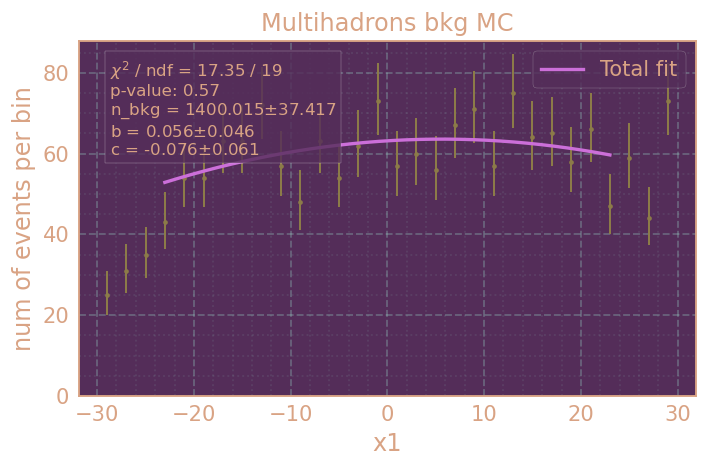

In [397]:
f.plot((-30, 30), bins=30, title='Multihadrons bkg MC', xtitle='x1', ytitle='num of events per bin', lw=2, 
        alpha=1, plot_bkg=False, fit_color='#CC6FD9', data_color='#8C7B48', bbox_color='#542D59', print_fixed_vals=False);

In [398]:
fit2poly = pyfit.FitPoly2(fit_range_bkg)
fmc = pyfit.Fitter(df_mcq.x1, fit2poly, dict(n_sig=len(df_mcq.x1), m=0, sL=1, sR=1, aL=1, aR=1, n_bkg=0, b=0, c=0),
            fit_range=fit_range_bkg, lims=f.get_limits(n_sigmas=0, include=['b', 'c'], 
            my_lims=dict(n_sig=(0, None), m=(-20, 20), sL=(0.1, None), sR=(0.1, None), aL=(0, None), aR=(0, None), n_bkg=(0, 0))) )
fmc.fit()

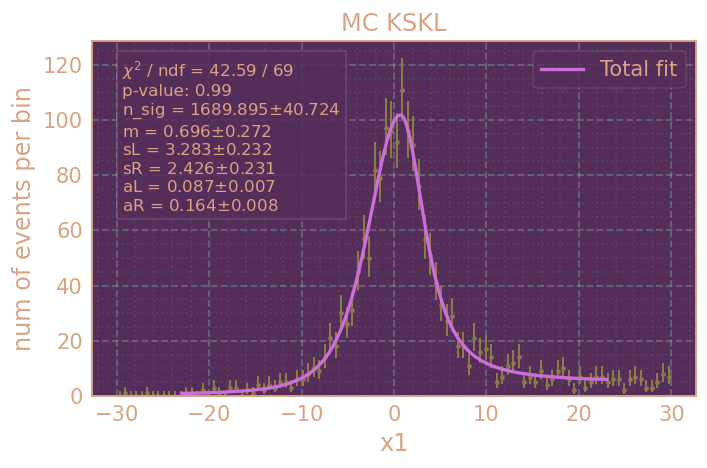

In [399]:
hist_rng, bins = (-30, 30), 100
fmc.plot(hist_rng, bins=bins, title='MC KSKL', xtitle='x1', ytitle='num of events per bin', lw=2, 
        alpha=1, fit_color='#CC6FD9', data_color='#8C7B48', bbox_color='#542D59', print_fixed_vals=False);

In [400]:
lims_mc = fmc.get_limits(n_sigmas=3, include=['sR', 'sL', 'aL', 'aR', 'm'])
lims_mc['n_bkg'] = (0, None)
lims_mc['b'] = (f.get_params()['b'], f.get_params()['b'])
lims_mc['c'] = (f.get_params()['c'], f.get_params()['c'])

In [401]:
pars_mc = fmc.get_params()
pars_mc['n_bkg'] = 100

In [402]:
f2 = pyfit.Fitter(dfq.x1, fit2poly, pars_mc,#dict(n_sig=100, m=0, sL=1, sR=1, aL=1, aR=1, n_bkg=100, b=1, c=0),
            fit_range=fit_range_bkg, lims=lims_mc, sigmas=fmc.get_sigmas(exclude=['n_sig', 'n_bkg',  'b', 'c', 'm']) )
f2.fit()

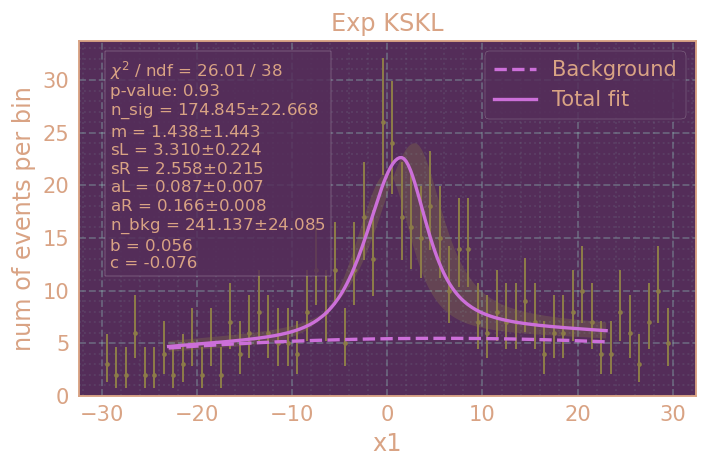

In [404]:
hist_rng, bins = (-30, 30), 60
f2.plot(hist_rng, bins=bins, title='Exp KSKL', xtitle='x1', ytitle='num of events per bin', lw=2, 
        alpha=1, plot_bkg=True, fit_color='#CC6FD9', data_color='#8C7B48', bbox_color='#542D59', fill_errors=True);

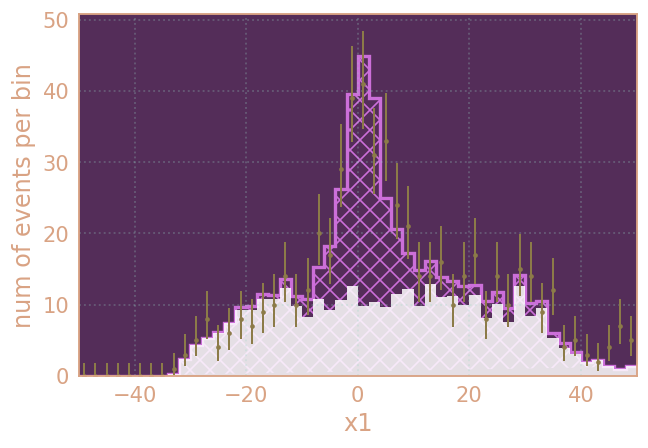

In [406]:
bins, range = 50, (-50, 50)
dm = f2.m.values['m'] - fmc.m.values['m']
bkg, sig = df_mltq.query('finalstate_id!=8').x1, df_mcq.x1 + dm
bkg_weight = f2.m.values['n_bkg']/((bkg < fit_range_bkg[1]) & (bkg > fit_range_bkg[0])).sum()
sig_weight = f2.m.values['n_sig']/((sig < fit_range_bkg[1]) & (sig > fit_range_bkg[0])).sum()
bkg_hist, _, _ = plt.hist(bkg, weights=np.ones_like(bkg)*bkg_weight, bins=bins, range=range, alpha=0.85, color='white');
plt.hist(sig, weights=np.ones_like(sig)*sig_weight, bins=bins, range=range, histtype='step', lw=2, hatch=r'\\//', bottom=bkg_hist, zorder=0, color='#CC6FD9');
pys.hep_histo(dfq.x1, range=range, bins=bins)
plt.xlabel('x1')
plt.ylabel('num of events per bin')
plt.xlim(range);

#### triggers

In [407]:
temp = dfq.query(f'(x1>{fit_range_bkg[0]})&(x1<{fit_range_bkg[1]})').trigbits
trig_eff = kskl.trigger_efficiency(temp)
trig_eff

{'T': (0.8452830188679246, 0.022173244467849067),
 'C': (0.5941644562334217, 0.025257041303424096),
 'TC': (0.9372103498323407, 0.009810530097159464)}

#### write fit

In [408]:
fit_pars, fit_errs = f2.get_params(), f2.get_sigmas(exclude=[])
fit_pars_mc, fit_errs_mc = fmc.get_params(), fmc.get_sigmas(exclude=[])

res_dict = dict(
    elabel=elabel, n_sig=fit_pars['n_sig'], n_sig_err=fit_errs['n_sig'],
    n_bkg=fit_pars['n_bkg'], n_bkg_err=fit_errs['n_bkg'],
    n_sig_mc=fit_pars_mc['n_sig'], n_sig_mc_err=fit_errs_mc['n_sig'],
    trig_eff=trig_eff['TC'][0], trig_eff_err=trig_eff['TC'][1],
    range_min=fit_range_bkg[0], range_max=fit_range_bkg[1],
)

In [283]:
fit_df = fit_df.append(res_dict, ignore_index=True)
fit_df.tail()

,elabel,n_sig,n_sig_err,n_bkg,n_bkg_err,n_sig_mc,n_sig_mc_err,trig_eff,trig_eff_err,range_min,range_max
11,950_15942,5.889966e-05,1.236013,73.005318,1.465902,740.010899,27.464649,0.985495,0.006873,-23.0,23.0
12,970_16068,1.877384e+01,8.402352,63.206349,10.724532,900.962196,29.638004,0.973709,0.009909,-25.0,25.0
13,980_16189,2.818190e-11,0.578283,41.999638,6.497778,1059.015363,32.409033,0.944056,0.024296,-25.0,25.0
14,990_16304,9.491345e+00,6.100986,31.486106,7.701657,1372.057796,36.506158,0.987179,0.008001,-23.0,23.0
15,960_16492,1.606861e+01,7.027505,39.896394,8.555799,881.994083,29.836935,0.956019,0.019876,-23.0,23.0


In [292]:
# fit_df.to_csv('../csv/HIGH/results/fit_result.csv', index=False)

### MC $\gamma$ energy

In [293]:
from pylib.regeff import RegEff
df_resunimc = pd.DataFrame()

In [294]:
SEASON = 'HIGH12'
df_total_info = kskl.season_csv_table(SEASON)
df_signal = pd.read_csv(f'../csv/{SEASON}/results/fit_result.csv')
df_signal.head()

,elabel,n_sig,n_sig_err,n_bkg,n_bkg_err,n_sig_mc,n_sig_mc_err,trig_eff,trig_eff_err,range_min,range_max
0,640_14606,177.322365,22.601337,256.650370,24.329324,1706.968170,41.315083,0.939415,0.009370,-25.0,25.0
1,680_14880,107.688260,21.936281,332.306213,25.621467,1431.004476,37.828675,0.954199,0.007190,-25.0,25.0
2,720_15027,83.637805,1.805244,318.349749,1.810784,1427.795242,38.085024,0.960038,0.006517,-25.0,25.0
3,760_15149,101.791441,16.906301,278.233451,21.499251,2826.033968,53.160800,0.975721,0.005419,-25.0,25.0
4,800_15287,199.790165,19.942763,217.209851,20.370257,4194.412658,64.551708,0.983858,0.004500,-25.0,25.0


In [295]:
df_total_info = pd.merge(df_total_info, df_signal[['elabel', 'range_min', 'range_max']], on='elabel')

In [296]:
def process_uniform(df_cuts: list, df_totals: list, bins=80):
    
    rng = (df_totals[0].sim_gamma_energy.min(), df_totals[0].sim_gamma_energy.max())
    dat0, dat1 = None, None
    for df_cut, df_total in zip(df_cuts, df_totals):
        dat0_, bins = np.histogram(df_total.sim_gamma_energy, bins=bins, range=rng)
        dat1_, bins = np.histogram(df_cut.sim_gamma_energy, bins=bins, range=rng)
        dat0 = dat0_ if dat0 is None else dat0 + dat0_
        dat1 = dat1_ if dat1 is None else dat1 + dat1_
    
    values = (dat1+1)/(dat0+2)
    errors = np.sqrt( (dat1+1)*(dat1+2)/(dat0+2)/(dat0+3) - ((dat1+1)/(dat0+2))**2 )
    return (values, errors, (bins[:-1]+bins[1:])/2)

In [297]:
it = df_total_info.iterrows()

In [379]:
idx, row = next(it)
row

StopIteration: 

In [380]:
tr_ph_mcuni = kskl.open_tree(row['mc_tree_kskl_uniform'])
df_radph0 = kskl.simphoton_energy_df(tr_ph_mcuni)


df_mcuni = kskl.selection_df(tr_ph_mcuni, finalstate_id=True, radiative_photons=True)
df_mcuni = point_cut(df_mcuni, row['emeas'])
df_mcuni = df_mcuni.query(f'(x1<{row["range_max"]})&(x1>{row["range_min"]})')

In [381]:
tr_ph_mc = kskl.open_tree(row['mc_tree_kskl_mcgpj'])
df_radph0_1 = kskl.simphoton_energy_df(tr_ph_mc)

df_mc_1 = kskl.selection_df(tr_ph_mc, finalstate_id=True, radiative_photons=True)
df_mc_1 = point_cut(df_mc_1, row['emeas'])
df_mc_1 = df_mc_1.query(f'(x1<{row["range_max"]})&(x1>{row["range_min"]})')

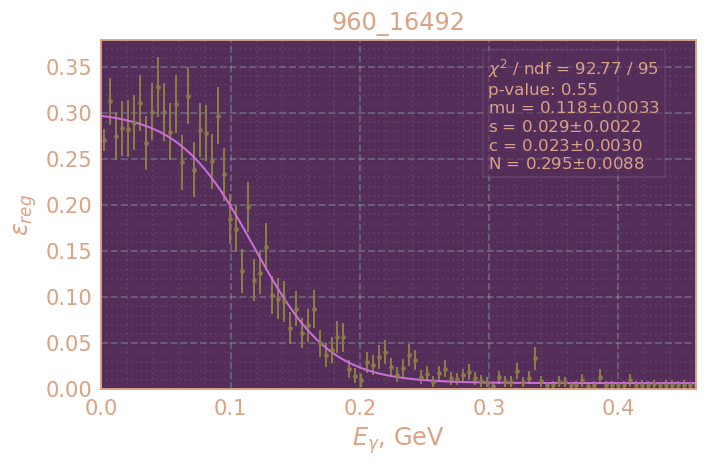

In [377]:
dat = process_uniform([df_mcuni, df_mc_1], [df_radph0, df_radph0_1], bins=100)
fit_res = RegEff.fit_data(dat[0], dat[1], dat[2], mu0=0.05, s0=1/90, name=row['elabel'], fit_color='#CC6FD9', data_color='#8C7B48', bbox_color='#542D59')
fit_res = fit_res.reset_index().rename({'index': 'elabel'}, axis=1)
plt.tight_layout()
# plt.savefig(f'images/regeff17/{row["elabel"]}.png', dpi=120)

In [378]:
df_resunimc = df_resunimc.append(fit_res, ignore_index=True)
df_resunimc.tail()

,elabel,mu,s,c,N,mu_err,s_err,c_err,N_err,eff0,eff0_err
11,950_15942,0.107792,0.035035,0.016719,0.345279,0.004467,0.002424,0.002805,0.013498,0.335832,0.012884
12,970_16068,0.117333,0.035550,0.018751,0.306582,0.004242,0.002518,0.003025,0.010736,0.301431,0.010293
13,980_16189,0.118471,0.036871,0.019460,0.298154,0.000010,0.000003,0.002625,0.005930,0.292425,0.006615
14,990_16304,0.110735,0.035906,0.019510,0.315401,0.004123,0.002738,0.002887,0.010724,0.307748,0.009798
15,960_16492,0.118137,0.029244,0.022786,0.295227,0.003291,0.002209,0.003000,0.008844,0.296847,0.008795


In [384]:
# df_resunimc.to_csv('../csv/HIGH/results/uniform_mc_result.csv', index=False)

### Radcors

In [385]:
from pylib.radcors import RadCor
from pylib.regeff import RegEff

In [386]:
SEASON = 'HIGH12'

df_total_info = kskl.season_csv_table(SEASON).set_index('elabel')
df_signal = pd.read_csv(f'../csv/{SEASON}/results/fit_result.csv').set_index('elabel')
df_reg_eff = pd.read_csv(f'../csv/{SEASON}/results/uniform_mc_result.csv').set_index('elabel')

df_total_info = pd.concat([df_total_info, df_signal, df_reg_eff], axis=1, join='inner').reset_index()

In [387]:
df_fit = pd.read_csv('../data/other/kskl_cs.csv', index_col=0)
df_radcors = pd.DataFrame()
r = RadCor(df_fit.emeas*0.5e3, df_fit.cs_born)

for index, j in df_total_info.iterrows():
    elabel, emeas = j['elabel'], j['emeas']
    rad, rad_err = r.F_Radcor(j['emeas'], j[['mu', 's', 'c', 'N']])/RegEff.sigFunc(0, *j[['mu', 's', 'c', 'N']])
    radcor_row = dict(elabel=elabel, emeas=emeas, radcor=rad, radcor_err=rad_err)
    df_radcors = df_radcors.append(radcor_row, ignore_index=True)
    
# df_radcors.to_csv('../csv/HIGH/results/radcors_result.csv', index=False)

### Plot CS

In [388]:
def cs_season(SEASON: str):
    df_total_info = kskl.season_csv_table(SEASON).set_index('elabel')
    df_signal = pd.read_csv(f'../csv/{SEASON}/results/fit_result.csv').set_index('elabel')
    df_reg_eff = pd.read_csv(f'../csv/{SEASON}/results/uniform_mc_result.csv').set_index('elabel')
    df_radcors = pd.read_csv(f'../csv/{SEASON}/results/radcors_result.csv').set_index('elabel')

    df_total_info = pd.concat([df_total_info, df_signal, df_reg_eff, df_radcors], axis=1, join='inner').reset_index()
    df_total_info = df_total_info.loc[:,~df_total_info.columns.duplicated()]
    
    cs = df_total_info['n_sig']/df_total_info['lum_exp']/df_total_info['trig_eff']/df_total_info['eff0']/df_total_info['radcor']
    cs_err = cs*(df_total_info['n_sig_err']/df_total_info['n_sig'])
    return {'emeas': df_total_info.emeas, 'cs': cs, 'cs_err': cs_err}

In [390]:
cs_17 = cs_season('HIGH17')
cs_19 = cs_season('HIGH19')
cs_12 = cs_season('HIGH12')

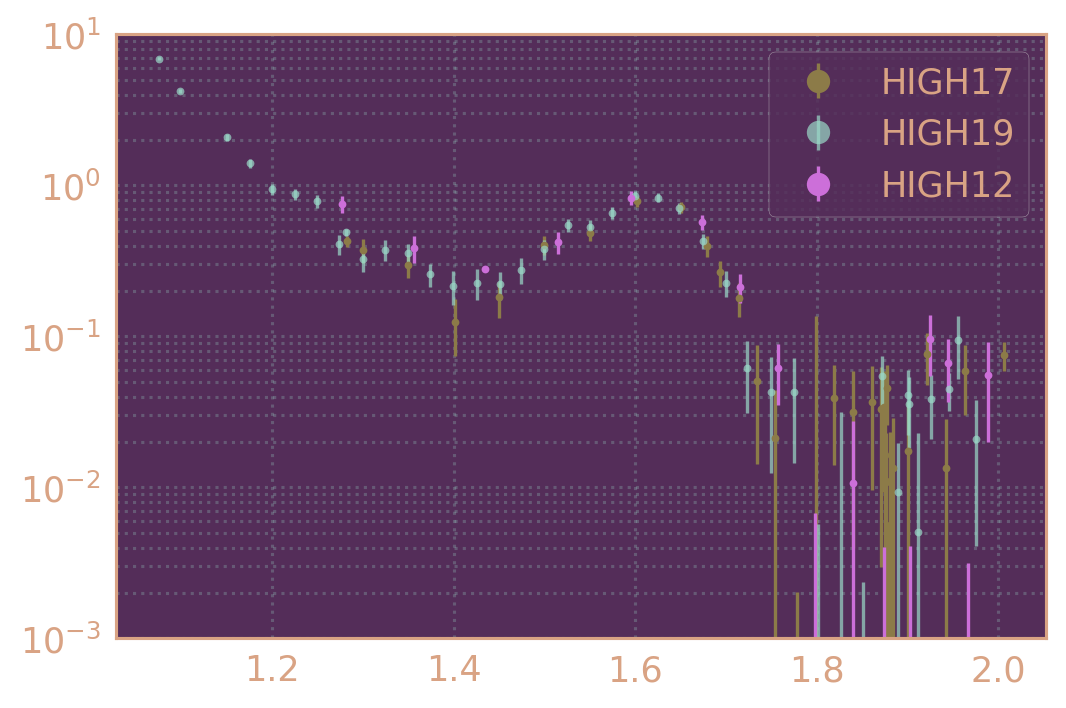

In [412]:
plt.figure(dpi=200)
plt.errorbar(cs_17['emeas']*2e-3, cs_17['cs'], yerr=cs_17['cs_err'], fmt='.', label='HIGH17')
plt.errorbar(cs_19['emeas']*2e-3, cs_19['cs'], yerr=cs_19['cs_err'], fmt='.', alpha=0.7, label='HIGH19')
plt.errorbar(cs_12['emeas']*2e-3, cs_12['cs'], yerr=cs_12['cs_err'], fmt='.', label='HIGH12')
plt.ylim(1e-3, 10)
plt.legend()
plt.yscale('log')